In [1]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import pandas as pd
import nltk
from nltk.corpus import gutenberg
from gensim.parsing.preprocessing import remove_stopwords
import urllib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn import metrics
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import  wordnet
from nltk.stem import WordNetLemmatizer, LancasterStemmer, PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import wordcloud
from wordcloud import WordCloud
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.evaluate import bias_variance_decomp
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import names

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Creating the books DataSet**

This method prepares the passed book text by removing stop words and punctuation marks then dividing it to paritions

In [3]:
def get_book_part(book_txt, flg_stemm, flg_lemm,no_words_part,no_part):
  if len(book_txt) == 0 or no_words_part <=0 or no_part <= 0:
    raise Exception("Invalid arguments sent to get_book_part function")
  
  #remove stop words from the book text, using code from https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
  stop_words = set(stopwords.words('english'))
  book_words = word_tokenize(book_txt)
  filtered_book_words = book_words
  filtered_book_words = [w for w in filtered_book_words if not w.lower() in stop_words]
  # removing punctuation marks and keeping words only, using code from https://stackoverflow.com/a/41024113
  filtered_book_words=[word.lower() for word in filtered_book_words if word.isalpha()]
  # stemmer = LancasterStemmer()
  # stemmed_words = [stemmer.stem(w) for w in filtered_book_words]
  # print(stemmed_words)

  # lemmatizer = WordNetLemmatizer()
  # limmatized_words = [lemmatizer.lemmatize(w) for w in stemmed_words]
  # print(limmatized_words)
  #create book paritions
  if flg_stemm == True:
    stemmer = LancasterStemmer()
    filtered_book_words = [stemmer.stem(w) for w in filtered_book_words]
    # print(filtered_book_words)
                
    ## Lemmatisation (convert the word into root word)
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    filtered_book_words = [lem.lemmatize(word) for word in filtered_book_words]
  part_lst = []
  part = []
  #skipping the first 500 words to skip introduction
  for word in filtered_book_words[100:]:
    #check if the word is a valid word
    part.append(word)
    if len(part) == no_words_part:
      part_lst.append(part)
      # print(" ".join(part)) #prints part sentence
      part = []
      if len(part_lst) == no_part:
        break  
  #if the part is not empty, then the words were not enough to create a full part
  if len(part)>0:
    print("WARNING: book words were not enough to create full partitions")
  return part_lst


This method downloads book from url and returns the book text only

In [4]:
def get_book_txt(book_url):
  response = urllib.request.urlopen(book_url)
  # Read url of the book
  book_data = response.read().decode('utf-8')
  #convert book binary data to string
  book_txt = str(book_data)
  #skip the text added before and after the actual book content
  book_txt_parts = re.split(r"\*\*\* .* \*\*\*", book_txt, 3)
  return book_txt_parts[1]

This method appends passed books paritions to passed dataframe

In [5]:
#appends passed book partitions to dataframe
def add_parts_to_dataframe(parts,label,df):
  rows_lst = []
  for part in parts:
    rows_lst.append(pd.Series([part, label] ,index=df.columns))
  df = df.append(rows_lst,ignore_index=True)
  return df

## Creating the books dataset

In [6]:
#Downloads book from gutenburg, partitions and appends partition to passed dataframe
def part_books_and_append_df(books_info_lst,books_df,no_words_part=100,no_part=200,flg_stemm=True, flg_lemm=False):
  for book_info in books_info_lst:
    print(f"Processing book {book_info[3]}"+"...")
    book_parts = get_book_part(get_book_txt(book_info[0]),flg_stemm,flg_lemm,no_words_part,no_part)
    if len(book_parts) < no_part:
      print(f"WARNING: Text book words were not sufficient to create requested partitions, Only {len(book_parts)} partition were created, \nPartitions wont be added to the final result\n")
      continue
    else:
      books_df = add_parts_to_dataframe(book_parts,book_info[2],books_df)
    print("book paritiones added to dataframe successfully.\n")
  return books_df

In [7]:
books_lst = [("https://www.gutenberg.org/cache/epub/17866/pg17866.txt","H. BEAM PIPER","a","Murder in the Gunroom"),
           ("https://www.gutenberg.org/files/1703/1703-0.txt","E. W. Hornung","b","Dead Men Tell No Tales"),
           ("https://www.gutenberg.org/files/1159/1159-0.txt","Sax Rohmer","c","Fire-Tongue"), 
           ("https://www.gutenberg.org/files/58866/58866-0.txt","Agatha Christie","d","The Murder on the Links"), 
           ("https://www.gutenberg.org/files/1563/1563-0.txt","Maurice Leblanc","e","The Crystal Stopper")]


no_words_part=100
no_part=200
books_df = pd.DataFrame(columns=['Partition','Label'])
books_df = part_books_and_append_df(books_lst,books_df,no_words_part,no_part,False,False)

#shuffling books data
books_df = books_df.sample(frac=1,ignore_index=True)
#add a new col that contains the joined paritioned text
books_df['Partition Text'] = books_df['Partition'].str.join(" ")
display(books_df)

Processing book Murder in the Gunroom...
book paritiones added to dataframe successfully.

Processing book Dead Men Tell No Tales...
book paritiones added to dataframe successfully.

Processing book Fire-Tongue...
book paritiones added to dataframe successfully.

Processing book The Murder on the Links...
book paritiones added to dataframe successfully.

Processing book The Crystal Stopper...
book paritiones added to dataframe successfully.



Partition Label  \
0    [never, table, harley, sir, charles, god, rest...     c   
1    [grown, tremulous, extended, hands, groping, m...     c   
2    [chosen, time, joking, said, dourly, third, qu...     c   
3    [butler, went, length, reasons, thinking, desc...     a   
4    [daubreuil, monsieur, renauld, paused, delicat...     d   
..                                                 ...   ...   
995  [opened, found, daubrecq, time, lupin, declare...     e   
996  [collectors, think, confederate, revolvers, br...     a   
997  [whoever, owned, pasted, slip, paper, undersid...     a   
998  [walks, rope, god, grace, without, mishap, tim...     b   
999  [stood, breathless, outside, lighted, windows,...     b   

                                        Partition Text  
0    never table harley sir charles god rest said i...  
1    grown tremulous extended hands groping movemen...  
2    chosen time joking said dourly third question ...  
3    butler went length reasons thinking described ...  
4    daubreuil monsieur renauld paused delicately e...  
..                                                 ...  
995  opened found daubrecq time lupin declared yes ...  
996  collectors think confederate revolvers brass f...  
997  whoever owned pasted slip paper underside stoc...  
998  walks rope god grace without mishap time think...  
999  stood breathless outside lighted windows kirby...  

[1000 rows x 3 columns]

# **Data Exploration and visualization**

**Uni-grams and Bi-grams Visualizations**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


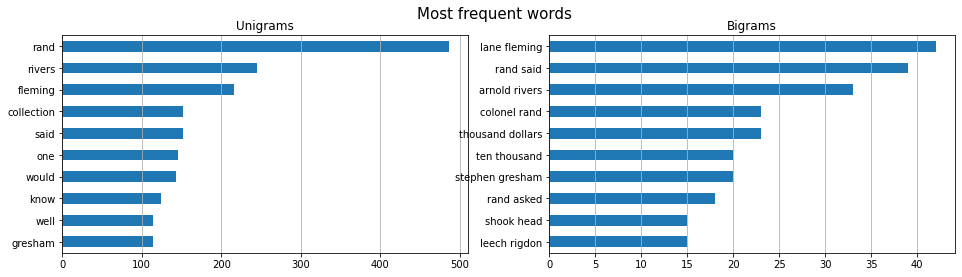

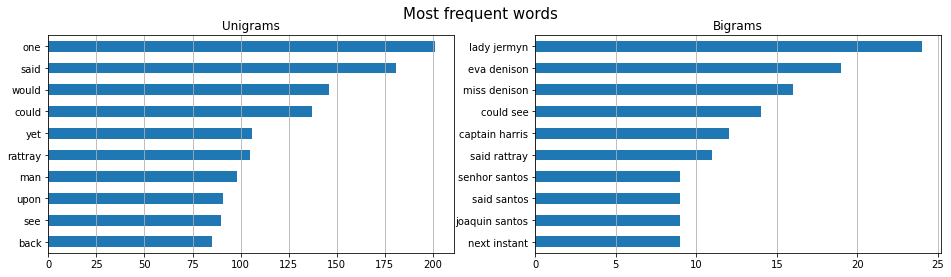

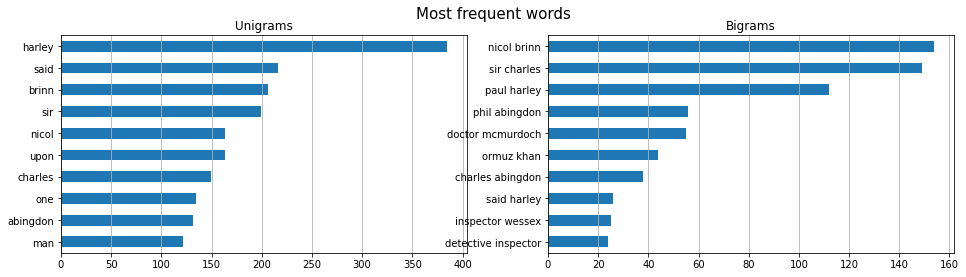

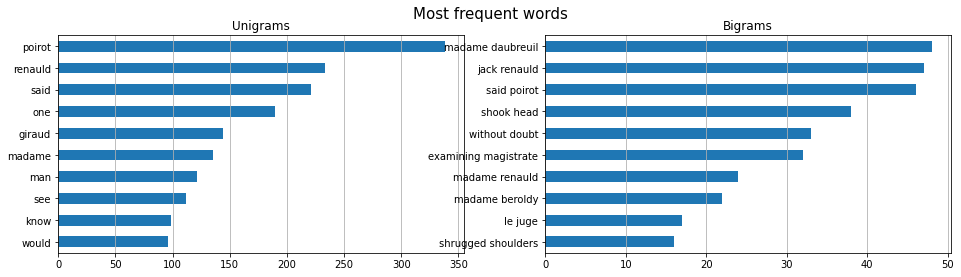

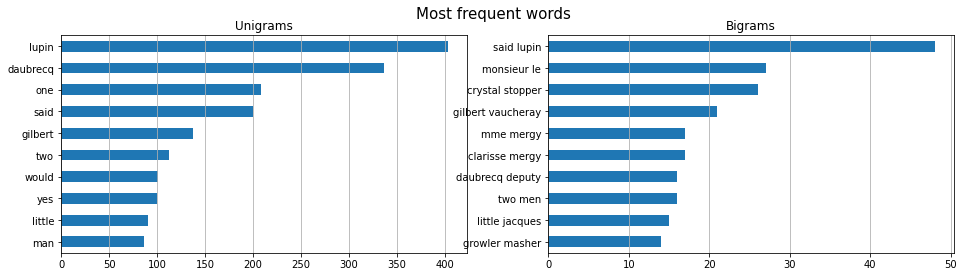

In [8]:
top=10
nltk.download('punkt')
## for vectorizer
from sklearn import feature_extraction, manifold
lis=['a','b','c','d','e']
for i in lis:
  y=i
  corpus = books_df[books_df["Label"]==y]["Partition Text"]
  lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
  fig.suptitle("Most frequent words", fontsize=15)
      
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
      
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.show()

**Word Cloud Visualization**

Books Word Cloud

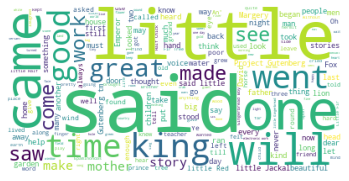

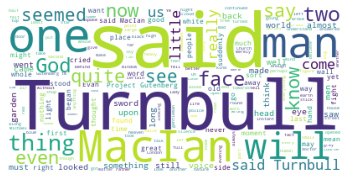

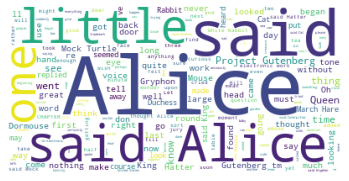

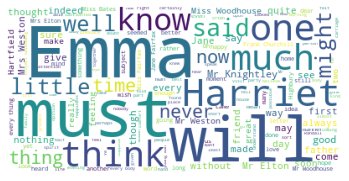

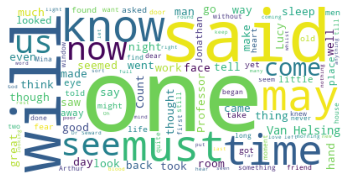

In [9]:
book_1 = urllib.request.urlopen('https://www.gutenberg.org/cache/epub/473/pg473.txt')
txt1 = book_1.read().decode("utf8")

book_2 = urllib.request.urlopen('https://www.gutenberg.org/files/5265/5265-0.txt')
txt2 = book_2.read().decode("utf8")

book_3 = urllib.request.urlopen('https://www.gutenberg.org/files/11/11-0.txt')
txt3 = book_3.read().decode("utf8")

book_4 = urllib.request.urlopen('https://www.gutenberg.org/cache/epub/158/pg158.txt')
txt4 = book_4.read().decode("utf8")

book_5 = urllib.request.urlopen('https://www.gutenberg.org/cache/epub/345/pg345.txt')
txt5 = book_5.read().decode("utf8")

book_lis=[txt1 , txt2, txt3, txt4, txt5]
for book in book_lis:
  wc = WordCloud(background_color ='white').generate(str(book))
  fig = plt.figure(figsize = (6, 6),num=1)
  plt.axis('off')
  plt.imshow(wc, cmap=None)
  plt.show()


Books partitions Word Cloud

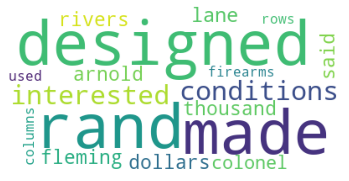

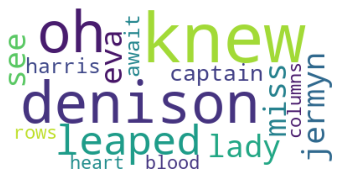

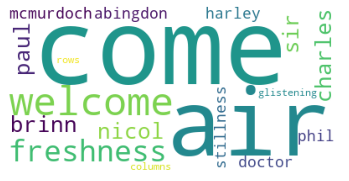

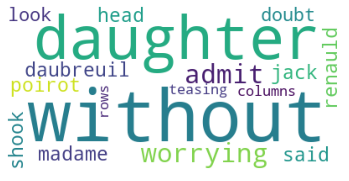

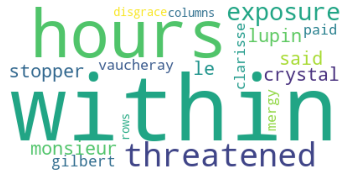

In [10]:
def generate_N_grams(text,ngram=2):
  
  temp=zip(*[text[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

a=defaultdict(int)
b=defaultdict(int)
c=defaultdict(int)
d=defaultdict(int)
e=defaultdict(int)

#get the count of every word in both the columns of df_train and df_test dataframes 
for text in books_df[books_df.Label=="a"].Partition:
  for word in generate_N_grams(text,2):
    a[word]+=1

#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in books_df[books_df.Label=="b"].Partition:
  for word in generate_N_grams(text,2):
    b[word]+=1    

#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in books_df[books_df.Label=="c"].Partition:
  for word in generate_N_grams(text,2):
    c[word]+=1  

#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in books_df[books_df.Label=="d"].Partition:
  for word in generate_N_grams(text,2):
    d[word]+=1  

#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in books_df[books_df.Label=="e"].Partition:
  for word in generate_N_grams(text,2):
    e[word]+=1  

df_a=pd.DataFrame(sorted(a.items(),key=lambda x:x[1],reverse=True))
df_b=pd.DataFrame(sorted(b.items(),key=lambda x:x[1],reverse=True))
df_c=pd.DataFrame(sorted(c.items(),key=lambda x:x[1],reverse=True))
df_d=pd.DataFrame(sorted(d.items(),key=lambda x:x[1],reverse=True))
df_e=pd.DataFrame(sorted(e.items(),key=lambda x:x[1],reverse=True))

word_lists =[df_a, df_b, df_c,df_d,df_e]

for i in word_lists:
 wc = WordCloud(background_color ='white').generate(str(i))
 fig = plt.figure(num=1)
 plt.axis('off')
 plt.imshow(wc, cmap=None)
 plt.show()

# **Feature Engineering**

**BOW**




In [11]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
#printing BOW feature matrix
tokens= count_vect.get_feature_names()
doc_names = ['Part{:d}'.format(idx) for idx, _ in enumerate(X_train_counts)]
df = pd.DataFrame(data=X_train_counts.toarray(), index=doc_names, columns=tokens)
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aarvo  aback  abaft  abandon  abandoned  abandoning  abashed  \
Part0        0      0      0        0          0           0        0   
Part1        0      0      0        0          0           0        0   
Part2        0      0      0        0          0           0        0   
Part3        0      0      0        0          0           0        0   
Part4        0      0      0        0          0           0        0   
...        ...    ...    ...      ...        ...         ...      ...   
Part995      0      0      0        0          0           0        0   
Part996      0      0      0        0          0           0        0   
Part997      0      0      0        0          0           0        0   
Part998      0      0      0        0          0           0        0   
Part999      0      0      0        0          0           0        0   

         abbalac  abducting  aberystwyth  ...  youngish  youngster  youth  \
Part0          0          0            0  ...         0          0      0   
Part1          0          0            0  ...         0          0      0   
Part2          0          0            0  ...         0          0      0   
Part3          0          0            0  ...         0          0      0   
Part4          0          0            0  ...         0          0      0   
...          ...        ...          ...  ...       ...        ...    ...   
Part995        0          0            0  ...         0          0      0   
Part996        0          0            0  ...         0          0      0   
Part997        0          0            0  ...         0          0      0   
Part998        0          0            0  ...         0          0      0   
Part999        0          0            0  ...         0          0      0   

         youths  zambesi  zeal  zealous  zigzag  zone  zorger  
Part0         0        0     0        0       0     0       0  
Part1         0        0     0        0       0     0       0  
Part2         0        0     0        0       0     0       0  
Part3         0        0     0        0       0     0       0  
Part4         0        0     0        0       0     0       0  
...         ...      ...   ...      ...     ...   ...     ...  
Part995       0        0     0        0       0     0       0  
Part996       0        0     0        0       0     0       0  
Part997       0        0     0        0       0     0       0  
Part998       0        0     0        0       0     0       0  
Part999       0        0     0        0       0     0       0  

[1000 rows x 12549 columns]

**TF-IDF**

In [12]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.toarray()
df_idf = pd.DataFrame(tf_transformer.idf_, index=tokens,columns=["idf_weights"])
display(df_idf['idf_weights'].nlargest(n=1000))

abashed        7.215608
abducting      7.215608
aberystwyth    7.215608
abhorred       7.215608
abject         7.215608
                 ...   
consult        7.215608
consumed       7.215608
consuming      7.215608
consummated    7.215608
consumption    7.215608
Name: idf_weights, Length: 1000, dtype: float64

**Stemming**

In [13]:
def process_part_text(part_row,stemm_flg,lemm_flg):
  Processed_part = part_row
  if stemm_flg:
    stemmer = LancasterStemmer()
    Processed_part = [stemmer.stem(w) for w in Processed_part]
  if lemm_flg:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    Processed_part = [lem.lemmatize(word) for word in Processed_part]
  return " ".join(Processed_part)


Partition Label  \
0    [never, table, harley, sir, charles, god, rest...     c   
1    [grown, tremulous, extended, hands, groping, m...     c   
2    [chosen, time, joking, said, dourly, third, qu...     c   
3    [butler, went, length, reasons, thinking, desc...     a   
4    [daubreuil, monsieur, renauld, paused, delicat...     d   
..                                                 ...   ...   
995  [opened, found, daubrecq, time, lupin, declare...     e   
996  [collectors, think, confederate, revolvers, br...     a   
997  [whoever, owned, pasted, slip, paper, undersid...     a   
998  [walks, rope, god, grace, without, mishap, tim...     b   
999  [stood, breathless, outside, lighted, windows,...     b   

                                        Partition Text  \
0    never table harley sir charles god rest said i...   
1    grown tremulous extended hands groping movemen...   
2    chosen time joking said dourly third question ...   
3    butler went length reasons thinking described ...   
4    daubreuil monsieur renauld paused delicately e...   
..                                                 ...   
995  opened found daubrecq time lupin declared yes ...   
996  collectors think confederate revolvers brass f...   
997  whoever owned pasted slip paper underside stoc...   
998  walks rope god grace without mishap time think...   
999  stood breathless outside lighted windows kirby...   

                                       Stemm Partition  
0    nev tabl harley sir charl god rest said irrit ...  
1    grown trem extend hand grop mov wom laugh shud...  
2    chos tim jok said dour third quest surpr must ...  
3    butl went leng reason think describ theft the ...  
4    daubreuil monsy renauld paus del eh without do...  
..                                                 ...  
995  op found daubrecq tim lupin decl ye daubrecq s...  
996  collect think conf revolv brass fram griswold ...  
997  whoev own past slip pap undersid stock low ram...  
998  walk rop god grac without mishap tim think twi...  
999  stood breathless outsid light window kirby hal...  

[1000 rows x 4 columns]

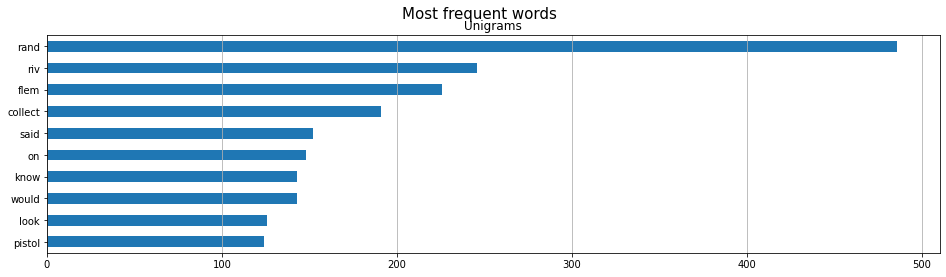

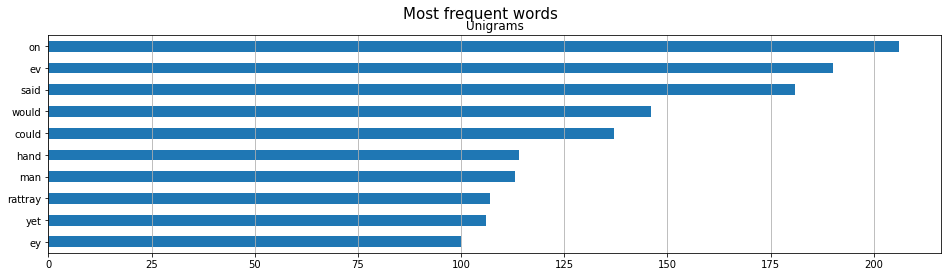

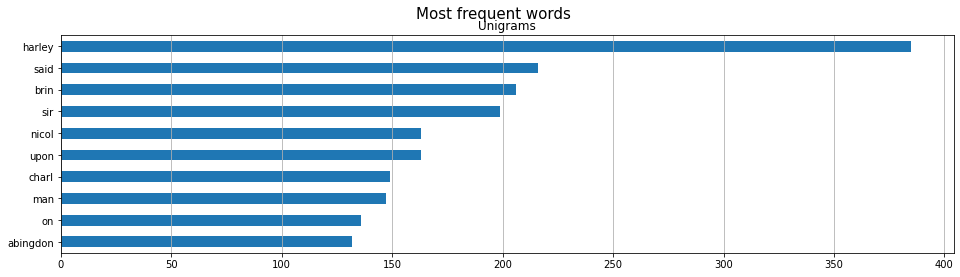

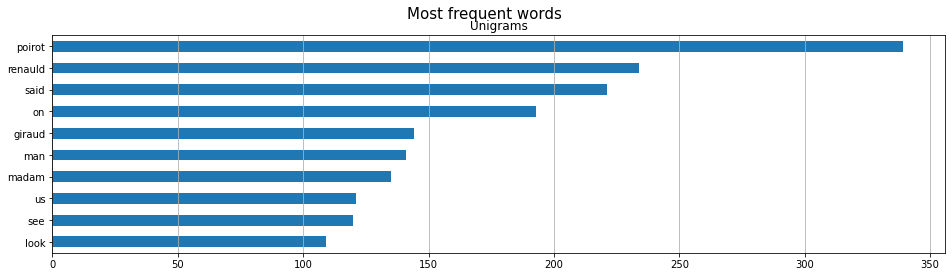

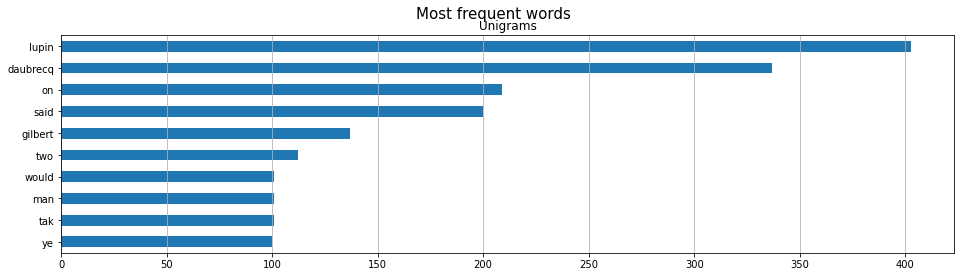

In [14]:
#getting stemmed parts
books_df['Stemm Partition'] = books_df.apply(lambda row : process_part_text(row[0],True,False),axis=1)
display(books_df)

#Visualizing first book uni grams after stemming
lis=['a','b','c','d','e']
for i in lis:
  y=i
  corpus = books_df[books_df["Label"]==y]['Stemm Partition']
  lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, figsize=(16,4))
  fig.suptitle("Most frequent words", fontsize=15)
      
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax, 
                    legend=False).grid(axis='x')
  ax.set(ylabel=None)
  plt.show()

**Lemmitization**

Partition Label  \
0    [never, table, harley, sir, charles, god, rest...     c   
1    [grown, tremulous, extended, hands, groping, m...     c   
2    [chosen, time, joking, said, dourly, third, qu...     c   
3    [butler, went, length, reasons, thinking, desc...     a   
4    [daubreuil, monsieur, renauld, paused, delicat...     d   
..                                                 ...   ...   
995  [opened, found, daubrecq, time, lupin, declare...     e   
996  [collectors, think, confederate, revolvers, br...     a   
997  [whoever, owned, pasted, slip, paper, undersid...     a   
998  [walks, rope, god, grace, without, mishap, tim...     b   
999  [stood, breathless, outside, lighted, windows,...     b   

                                        Partition Text  \
0    never table harley sir charles god rest said i...   
1    grown tremulous extended hands groping movemen...   
2    chosen time joking said dourly third question ...   
3    butler went length reasons thinking described ...   
4    daubreuil monsieur renauld paused delicately e...   
..                                                 ...   
995  opened found daubrecq time lupin declared yes ...   
996  collectors think confederate revolvers brass f...   
997  whoever owned pasted slip paper underside stoc...   
998  walks rope god grace without mishap time think...   
999  stood breathless outside lighted windows kirby...   

                                       Stemm Partition  \
0    nev tabl harley sir charl god rest said irrit ...   
1    grown trem extend hand grop mov wom laugh shud...   
2    chos tim jok said dour third quest surpr must ...   
3    butl went leng reason think describ theft the ...   
4    daubreuil monsy renauld paus del eh without do...   
..                                                 ...   
995  op found daubrecq tim lupin decl ye daubrecq s...   
996  collect think conf revolv brass fram griswold ...   
997  whoev own past slip pap undersid stock low ram...   
998  walk rop god grac without mishap tim think twi...   
999  stood breathless outsid light window kirby hal...   

                                        Lemm Partition  
0    never table harley sir charles god rest said i...  
1    grown tremulous extended hand groping movement...  
2    chosen time joking said dourly third question ...  
3    butler went length reason thinking described t...  
4    daubreuil monsieur renauld paused delicately e...  
..                                                 ...  
995  opened found daubrecq time lupin declared yes ...  
996  collector think confederate revolver brass fra...  
997  whoever owned pasted slip paper underside stoc...  
998  walk rope god grace without mishap time think ...  
999  stood breathless outside lighted window kirby ...  

[1000 rows x 5 columns]

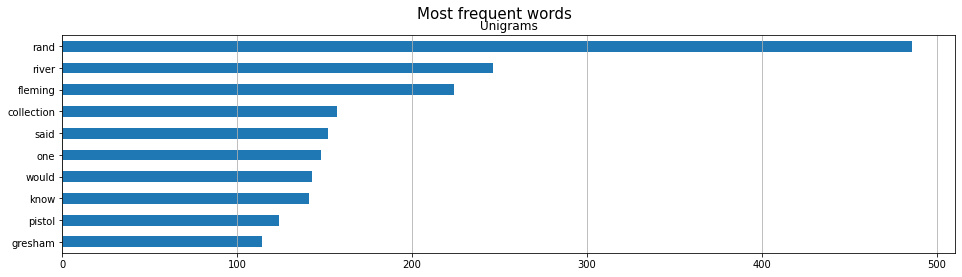

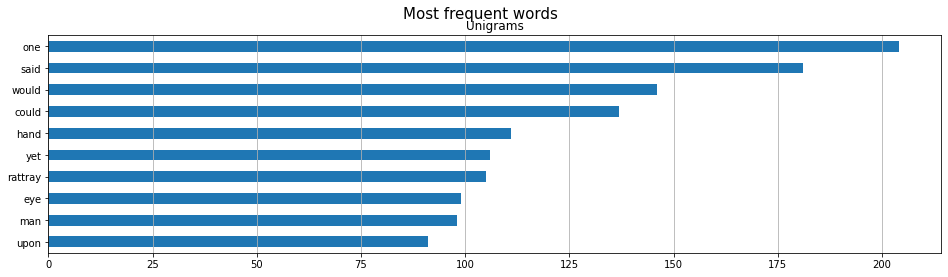

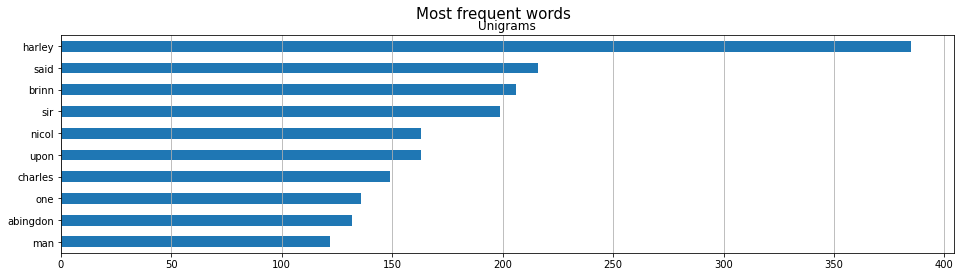

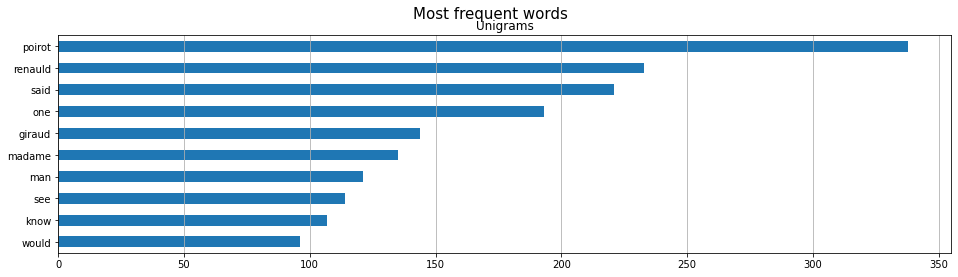

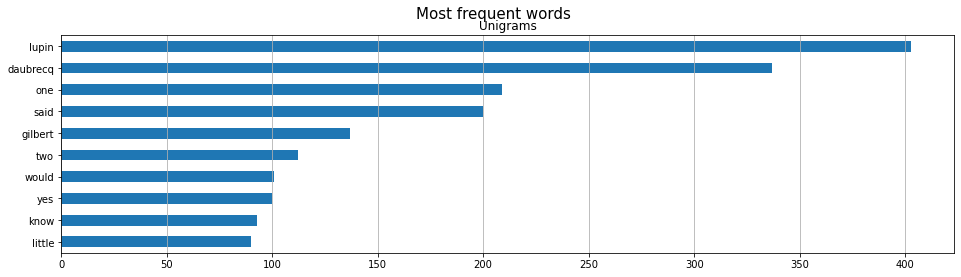

In [15]:
#getting lemmitized parts
books_df['Lemm Partition'] = books_df.apply(lambda row : process_part_text(row[0],False,True),axis=1)
display(books_df)

#Visualizing first book uni grams after Lemmitization
lis=['a','b','c','d','e']
for i in lis:
  y=i
  corpus = books_df[books_df["Label"]==y]['Lemm Partition']
  lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, figsize=(16,4))
  fig.suptitle("Most frequent words", fontsize=15)
      
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax, 
                    legend=False).grid(axis='x')
  ax.set(ylabel=None)
  plt.show()

## **Feature Selection**

Selecting top features from BOW

In [16]:
count_vect = CountVectorizer(min_df=50)
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
#printing BOW feature matrix
tokens= count_vect.get_feature_names()
doc_names = ['Part{:d}'.format(idx) for idx, _ in enumerate(X_train_counts)]
df = pd.DataFrame(data=X_train_counts.toarray(), index=doc_names, columns=tokens)
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abingdon  able  across  ago  ah  almost  along  already  also  \
Part0           1     0       0    0   0       0      0        0     0   
Part1           0     0       0    0   0       2      0        0     0   
Part2           2     0       0    0   0       1      0        0     1   
Part3           0     1       0    0   0       0      0        0     0   
Part4           0     0       0    1   0       0      0        0     1   
...           ...   ...     ...  ...  ..     ...    ...      ...   ...   
Part995         0     0       0    0   0       0      0        0     0   
Part996         0     0       0    0   0       0      0        1     0   
Part997         0     0       0    0   0       0      0        0     0   
Part998         0     0       0    0   0       0      0        1     0   
Part999         0     0       0    0   0       0      0        0     0   

         always  ...  woman  word  words  work  world  would  years  yes  yet  \
Part0         0  ...      0     0      0     0      0      0      0    0    0   
Part1         0  ...      2     0      0     0      0      0      0    0    0   
Part2         0  ...      0     0      2     0      0      0      0    0    0   
Part3         0  ...      0     0      0     1      0      0      0    1    0   
Part4         1  ...      1     0      0     0      0      1      0    0    0   
...         ...  ...    ...   ...    ...   ...    ...    ...    ...  ...  ...   
Part995       0  ...      0     0      0     0      0      2      0    2    0   
Part996       0  ...      0     0      0     0      0      0      0    0    0   
Part997       0  ...      0     0      0     0      1      0      0    0    0   
Part998       0  ...      0     0      0     0      0      0      0    0    1   
Part999       0  ...      0     0      0     0      0      0      0    0    0   

         young  
Part0        0  
Part1        0  
Part2        0  
Part3        0  
Part4        1  
...        ...  
Part995      0  
Part996      1  
Part997      0  
Part998      0  
Part999      1  

[1000 rows x 300 columns]

Using N-grams with BOW

In [17]:
count_vect = CountVectorizer(min_df=30,ngram_range=(2,2))
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
#printing BOW feature matrix
tokens= count_vect.get_feature_names_out()
doc_names = ['Part{:d}'.format(idx) for idx, _ in enumerate(X_train_counts)]
df = pd.DataFrame(data=X_train_counts.toarray(), index=doc_names, columns=tokens)
display(df)

arnold rivers  charles abingdon  could see  doctor mcmurdoch  \
Part0                0                 0          0                 0   
Part1                0                 0          0                 0   
Part2                0                 1          0                 2   
Part3                0                 0          0                 0   
Part4                0                 0          1                 0   
...                ...               ...        ...               ...   
Part995              0                 0          0                 0   
Part996              1                 0          0                 0   
Part997              0                 0          0                 0   
Part998              0                 0          0                 0   
Part999              0                 0          0                 0   

         lane fleming  last night  madame daubreuil  nicol brinn  ormuz khan  \
Part0               0           0                 0            0           1   
Part1               0           0                 0            2           0   
Part2               0           0                 0            1           0   
Part3               1           0                 0            0           0   
Part4               0           0                 1            0           0   
...               ...         ...               ...          ...         ...   
Part995             0           0                 0            0           0   
Part996             0           0                 0            0           0   
Part997             1           0                 0            0           0   
Part998             0           0                 0            0           0   
Part999             0           0                 0            0           0   

         paul harley  phil abingdon  rand said  said lupin  said poirot  \
Part0              2              1          0           0            0   
Part1              0              0          0           0            0   
Part2              0              0          0           0            0   
Part3              0              0          0           0            0   
Part4              0              0          0           0            0   
...              ...            ...        ...         ...          ...   
Part995            0              0          0           0            0   
Part996            0              0          1           0            0   
Part997            0              0          0           0            0   
Part998            0              0          0           0            0   
Part999            0              0          0           0            0   

         shook head  sir charles  without doubt  
Part0             0            1              0  
Part1             0            0              0  
Part2             0            1              0  
Part3             0            0              0  
Part4             1            0              2  
...             ...          ...            ...  
Part995           0            0              0  
Part996           0            0              0  
Part997           0            0              0  
Part998           0            0              0  
Part999           0            0              0  

[1000 rows x 17 columns]

# **Text Classification Models**

Splitting the data into training and test partitions

In [18]:
#encoding target col
label_enc = LabelEncoder()
books_df['EncodedLabel'] = label_enc.fit_transform(books_df['Label'])

#startify the data
books_train, books_test, target_train, target_test = train_test_split(books_df,books_df['EncodedLabel'], test_size=0.30, random_state=42,stratify=books_df['Label'])

#setting the number of folds to be used
cv = KFold(n_splits=10)

**SVM**

10-Folds Accuracy: 0.91 (+/- 0.07)


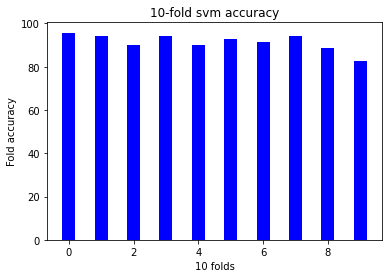

Avg Expected Error: 0.306
Bias: 0.231
Variance: 0.075


In [19]:
text_clf_SVM = Pipeline([
    ('vect', CountVectorizer(min_df=50)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])
text_clf_SVM.fit(books_train['Partition Text'], target_train)

predicted_SVM = text_clf_SVM.predict(books_test['Partition Text'])

scores = cross_val_score(text_clf_SVM, books_train['Partition Text'], target_train, cv = cv)
print("10-Folds Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold svm accuracy")
plt.show()

#transforming the data for variability and bias calculations
books_train_trans=text_clf_SVM['vect'].transform(books_train['Partition Text'].values)
books_train_trans=text_clf_SVM['tfidf'].transform(books_train_trans)
books_test_trans=text_clf_SVM['vect'].transform(books_test['Partition Text'].values)
books_test_trans=text_clf_SVM['tfidf'].transform(books_test_trans)

exp_err, bias, var = bias_variance_decomp(text_clf_SVM['clf'], books_train_trans, target_train.values, books_test_trans, target_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('Avg Expected Error: %.3f' % exp_err)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

**Decision Tree**

10-Folds Accuracy: 0.92 (+/- 0.06)


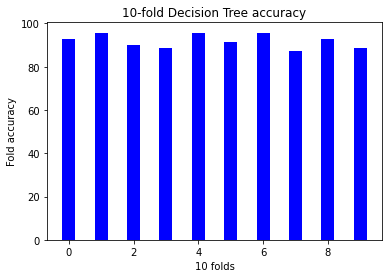

Avg Expected Error: 0.258
Bias: 0.118
Variance: 0.141


In [20]:
text_clf_dec_tree = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', tree.DecisionTreeClassifier()),
])
text_clf_dec_tree.fit(books_train['Partition Text'], target_train)
predicted_dec_Tree = text_clf_dec_tree.predict(books_test['Partition Text'])

scores = cross_val_score(text_clf_dec_tree, books_train['Partition Text'], target_train, cv = cv)
print("10-Folds Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold Decision Tree accuracy")
plt.show()

#transforming the data for variability and bias calculations
books_train_trans=text_clf_dec_tree['vect'].transform(books_train['Partition Text'].values)
books_train_trans=text_clf_dec_tree['tfidf'].transform(books_train_trans)
books_test_trans=text_clf_dec_tree['vect'].transform(books_test['Partition Text'].values)
books_test_trans=text_clf_dec_tree['tfidf'].transform(books_test_trans)

mse, bias, var = bias_variance_decomp(text_clf_dec_tree['clf'], books_train_trans, target_train.values, books_test_trans, target_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('Avg Expected Error: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

**K-Nearest Nieghbour**

10-Folds Accuracy: 0.93 (+/- 0.08)


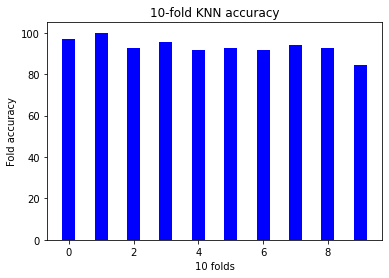

Avg Expected Error: 0.237
Bias: 0.072
Variance: 0.165


In [21]:
text_clf_KNN = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier()),
])
text_clf_KNN.fit(books_train['Partition Text'], target_train)
predicted_KNN = text_clf_KNN.predict(books_test['Partition Text'])

scores = cross_val_score(text_clf_KNN, books_train['Partition Text'], target_train, cv = cv)
print("10-Folds Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold KNN accuracy")
plt.show()

#transforming the data for variability and bias calculations
books_train_trans=text_clf_KNN['vect'].transform(books_train['Partition Text'].values)
books_train_trans=text_clf_KNN['tfidf'].transform(books_train_trans)
books_test_trans=text_clf_KNN['vect'].transform(books_test['Partition Text'].values)
books_test_trans=text_clf_KNN['tfidf'].transform(books_test_trans)

mse, bias, var = bias_variance_decomp(text_clf_KNN['clf'], books_train_trans, target_train.values, books_test_trans, target_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('Avg Expected Error: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

**Naive Bias**

10-Folds Accuracy: 0.97 (+/- 0.06)


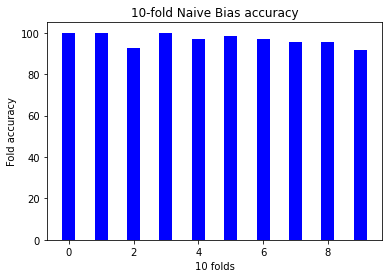

Avg Expected Error: 0.102
Bias: 0.056
Variance: 0.046


In [22]:
text_clf_NB = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf_NB.fit(books_train['Partition Text'], target_train)

predicted_NB = text_clf_NB.predict(books_test['Partition Text'])


scores = cross_val_score(text_clf_NB, books_train['Partition Text'], target_train, cv = cv)
print("10-Folds Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold Naive Bias accuracy")
plt.show()

#transforming the data for variability and bias calculations
books_train_trans=text_clf_NB['vect'].transform(books_train['Partition Text'].values)
books_train_trans=text_clf_NB['tfidf'].transform(books_train_trans)
books_test_trans=text_clf_NB['vect'].transform(books_test['Partition Text'].values)
books_test_trans=text_clf_NB['tfidf'].transform(books_test_trans)

mse, bias, var = bias_variance_decomp(text_clf_NB['clf'], books_train_trans, target_train.values, books_test_trans, target_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('Avg Expected Error: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

# **Champion Model Analysis**

Evaluating the model using test data

[[60  0  0  0  0]
 [ 0 58  1  0  1]
 [ 0  0 60  0  0]
 [ 0  2  0 57  1]
 [ 0  0  0  0 60]]


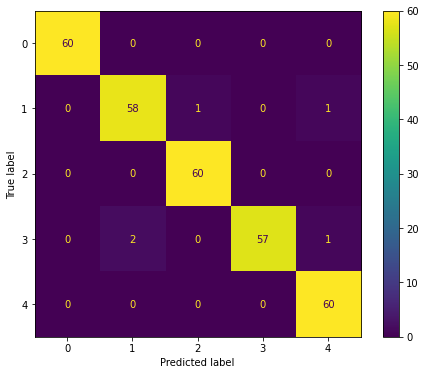

In [23]:
cm = confusion_matrix(target_test,predicted_NB)
print(cm)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions( target_test, predicted_NB, labels=text_clf_NB['clf'].classes_, ax=ax, colorbar=True)
plt.show()

**Visualizing Predictions**

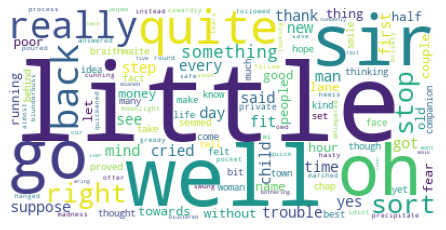

In [24]:
#Getting wrong predicitons
wrong_pred_indices = [i for i in range(len(target_test.values)) if target_test.values[i] != predicted_NB[i]]
wrong_pred_df = books_test.iloc[wrong_pred_indices,:]
# display(wrong_pred_df)
wrong_pred = str(wrong_pred_df['Partition Text'].str.cat(sep=' '))

#displaying the wrong predicitons words
wordcloud = WordCloud(background_color ='white',
                min_font_size = 5).generate(wrong_pred)
 
# plot the WordCloud image                      
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Feature Importance**

In [25]:
a_class_prob_sorted = text_clf_NB['clf'].feature_log_prob_[0, :].argsort()[::-1]
b_class_prob_sorted = text_clf_NB['clf'].feature_log_prob_[1, :].argsort()[::-1]
c_class_prob_sorted = text_clf_NB['clf'].feature_log_prob_[2, :].argsort()[::-1]
d_class_prob_sorted = text_clf_NB['clf'].feature_log_prob_[3, :].argsort()[::-1]
e_class_prob_sorted = text_clf_NB['clf'].feature_log_prob_[4, :].argsort()[::-1]

print("Book 'a' Important Features:" + str(np.take(text_clf_NB['vect'].get_feature_names(), a_class_prob_sorted[:10]))+"\n")
print("Book 'b' Important Features:" + str(np.take(text_clf_NB['vect'].get_feature_names(), b_class_prob_sorted[:10]))+"\n")
print("Book 'c' Important Features:" + str(np.take(text_clf_NB['vect'].get_feature_names(), c_class_prob_sorted[:10]))+"\n")
print("Book 'd' Important Features:" + str(np.take(text_clf_NB['vect'].get_feature_names(), d_class_prob_sorted[:10]))+"\n")
print("Book 'e' Important Features:" + str(np.take(text_clf_NB['vect'].get_feature_names(), e_class_prob_sorted[:10]))+"\n")

Book 'a' Important Features:['rand' 'rivers' 'fleming' 'pistols' 'collection' 'gresham' 'would' 'one'
 'well' 'like']

Book 'b' Important Features:['would' 'one' 'yet' 'said' 'could' 'never' 'still' 'upon' 'back' 'less']

Book 'c' Important Features:['harley' 'brinn' 'sir' 'nicol' 'nicol brinn' 'abingdon' 'sir charles'
 'charles' 'upon' 'paul']

Book 'd' Important Features:['poirot' 'renauld' 'madame' 'giraud' 'said' 'magistrate' 'villa' 'one'
 'monsieur' 'crime']

Book 'e' Important Features:['lupin' 'daubrecq' 'gilbert' 'one' 'clarisse' 'said' 'two' 'yes' 'shall'
 'thing']



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Decreasing Model Accuracy**

Remove characters names from books partitions

Accuracy: 0.87 (+/- 0.10)


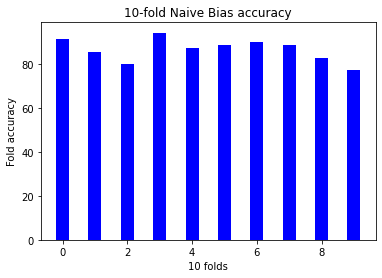

In [30]:
#removing some characters names
important_feat=['rand', 'fleming','gresham','santos','eva','harley', 'brinn', 'nicol', 'charles', 'abingdon', 'paul','poirot','renauld','giraud','lupin','daubrecq','gilbert','daubreuil']

text_clf_NB2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30,stop_words=important_feat)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf_NB2.fit(books_train['Partition Text'], target_train)

predicted_NB2 = text_clf_NB2.predict(books_test['Partition Text'])

scores = cross_val_score(text_clf_NB2, books_train['Partition Text'], target_train, cv = cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold Naive Bias accuracy")
plt.show()

**Test Stemming or lemmitizing the words**

Test Stemming books partitions

Accuracy: 0.98 (+/- 0.04)


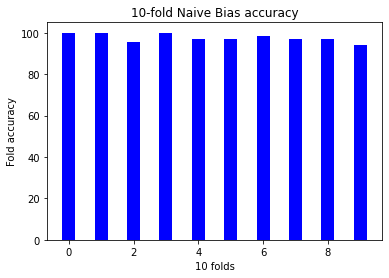

In [27]:
text_clf_NB3 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf_NB3.fit(books_train['Stemm Partition'], target_train)

predicted_NB3 = text_clf_NB3.predict(books_test['Stemm Partition'])

scores = cross_val_score(text_clf_NB3, books_train['Stemm Partition'], target_train, cv = cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold Naive Bias accuracy")
plt.show()

Test lemmetizing books partitions

Accuracy: 0.97 (+/- 0.05)


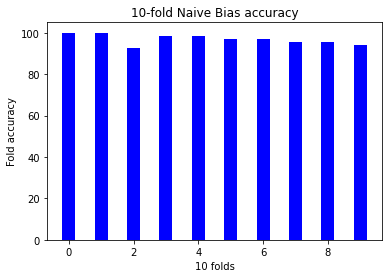

In [28]:
text_clf_NB4 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2),min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf_NB4.fit(books_train['Lemm Partition'], target_train)

predicted_NB4 = text_clf_NB4.predict(books_test['Lemm Partition'])

scores = cross_val_score(text_clf_NB4, books_train['Lemm Partition'], target_train, cv = cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#Plot K folds accuracy
plt.bar(np.arange(10), scores*100, color ='blue',width = 0.4) 
plt.xlabel("10 folds")
plt.ylabel("Fold accuracy")
plt.title("10-fold Naive Bias accuracy")
plt.show()